In [1]:
## Library importation

import numpy as np
from matplotlib import pyplot as plt
import shelve
import os
import time

In [2]:
## Function Definition

# Image plotting function
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')

# Database file existance checker function
def db_checker(db_main_name):
    c1 = os.path.exists("{}.dir".format(db_main_name))
    c2 = os.path.exists("{}.bak".format(db_main_name))
    c3 = os.path.exists("{}.dat".format(db_main_name))
    return (c1 and c2 and c3)

In [3]:
## Dataset set handling

# Train set
# Checking if the train set is saved as a database
if db_checker("Train.db"):
    # Reading the database train set
    with shelve.open("Train.db") as db:
        X_Train = db["X_Train"]
        y_Train = db["y_Train"]
else:
    # Reading the raw train set
    train_images_file = open('train-images.idx3-ubyte', 'rb')
    train_images_file.seek(4)
    num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
    train_images_file.seek(16)
    train_labels_file = open('train-labels.idx1-ubyte', 'rb')
    train_labels_file.seek(8)
    X_Train = []
    y_Train = []
    for n in range(num_of_train_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
        label_value = int.from_bytes(train_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        X_Train.append(image)
        y_Train.append(label)
    X_Train = np.array(X_Train)
    X_Train = np.reshape(X_Train, (X_Train.shape[0], -1)).transpose()
    y_Train = np.array(y_Train)
    y_Train = np.reshape(y_Train, (y_Train.shape[0], -1)).transpose()
    # Writting data into a python shelve database
    with shelve.open("Train.db") as db:
        db["X_Train"] = X_Train
        db["y_Train"] = y_Train

# Test set
# Checking if the test set is saved as a database
if db_checker("Test.db"):
    # Reading the database test set
    with shelve.open("Test.db") as db:
        X_Test = db["X_Test"]
        y_Test = db["y_Test"]
else:
    # Reading the raw test set
    test_images_file = open('t10k-images.idx3-ubyte', 'rb')
    test_images_file.seek(4)
    test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
    test_labels_file.seek(8)
    num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
    test_images_file.seek(16)
    X_Test = []
    y_Test = []
    for n in range(num_of_test_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
        label_value = int.from_bytes(test_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        X_Test.append(image)
        y_Test.append(label)
    X_Test = np.array(X_Test)
    X_Test = np.reshape(X_Test, (X_Test.shape[0], -1)).transpose()
    y_Test = np.array(y_Test)
    y_Test = np.reshape(y_Test, (y_Test.shape[0], -1)).transpose()
    
    # Writting data into a python shelve database
    with shelve.open("Test.db") as db:
        db["X_Test"] = X_Test
        db["y_Test"] = y_Test

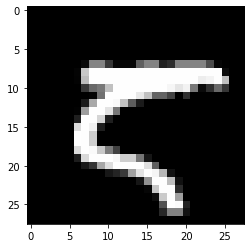

In [4]:
# Plotting random image from train set

index = np.random.randint(low = 0, high = X_Train.shape[1])
show_image(X_Train[:, index])

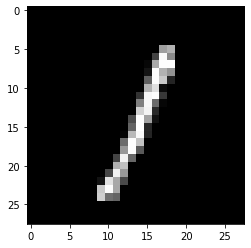

In [5]:
# Plotting random image from test set

index = np.random.randint(low = 0, high = X_Test.shape[1])
show_image(X_Test[:, index])

In [6]:
## Implementation of Activation Functions and their derivatives

class Activation_functions:
    
    def calculate_sigmoid(z):
        
        # Calculating sigmoid function
        return (1/(1+np.exp(-z)))
    
    
    def calculate_sigmoid_derivative(z):
        
        # Calculating derivative of the sigmoid function
        s_z = Activation_functions.calculate_sigmoid(z)
        return (s_z*(1-s_z))
    
    
    def calculate_softmax(z):
        
        # Calculating softmax function
        exp_z = np.exp(z)
        sum_exp_z = np.sum(exp_z, axis = 0)
        return exp_z/sum_exp_z
    
    
    def calculate_softmax_derivative(z):
        
        # Calculating derivative of the softmax function
        s_z = Activation_functions.calculate_softmax(z)
        return (s_z*(1-s_z))
    
    
    def calculate_relu(z):
        
        # Calculating relu function
        return np.heaviside(z, 1) * z
    
    
    def calculate_relu_derivative(z):
        
        # Calculating derivative of relu function
        return np.heaviside(z, 1)
    
    
    ac_funcs_supported = ["sigmoid", "softmax", "relu"]
    ac_funcs_dict = {"sigmoid": calculate_sigmoid, "softmax": calculate_softmax, "relu": calculate_relu}
    ac_funcs_der_dict = {"sigmoid": calculate_sigmoid_derivative, "softmax": calculate_softmax_derivative, "relu": calculate_relu_derivative}
    
    
    def __init__(self, model_ac_funcs):
        
        # Selecting model activation function and its derivative
        self.ac_funcs = [None]
        self.ac_funcs_der = [None]
        for ac_func in model_ac_funcs:
            if ac_func in Activation_functions.ac_funcs_supported:
                self.ac_funcs.append(Activation_functions.ac_funcs_dict[ac_func])
                self.ac_funcs_der.append(Activation_functions.ac_funcs_der_dict[ac_func])
            else:
                raise Exception("The function: {} is not defined as an activation function in this program".format(ac_func))

In [7]:
## Implementation of Artificial Neural Networks model

class ANN_Model(Activation_functions):
    
    
    def __init__(self, model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size, warm_start = False):
        
        # Setting model size attributes
        self.model_architecture = model_architecture
        self.num_layers = len(self.model_architecture)
        
        # Setting model hyper-parameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.warm_start = warm_start
        self.trained = False
        self.initialized = False
        self.initial_weights_biases = []
        
        # Preallocate model weights and biases (zero values)
        self.theta = []
        self.b = []
        for l in range(1, self.num_layers):
            self.theta.append(np.zeros((self.model_architecture[l], self.model_architecture[l-1])))
            self.b.append(np.zeros((self.model_architecture[l], 1)))
        
        # Selecting model activation function and its derivative
        super().__init__(model_ac_funcs)
    
    
    def initialize_neurons(self, num_samples):
        
        # Initializing model neurons
        self.z = []
        self.a = []
        for l in range(self.num_layers):
            self.z.append(np.zeros((self.model_architecture[l], num_samples)))
            self.a.append(np.zeros((self.model_architecture[l], num_samples)))
    
    
    def initialize_weights_and_biases(self):
        
        # Initializing model weights and biases
        for l in range(1, self.num_layers):
            self.theta[l-1][:, :] = np.random.normal(size = (self.model_architecture[l], self.model_architecture[l-1]))
            self.b[l-1][:, :] = 0
        self.initial_weights_biases = (self.theta.copy(), self.b.copy())
        self.initialized = True
    
    
    def initialize_gradients(self, num_samples):
        
        # Initializing model gradients for neurons, weights and biases
        self.grad_a = []
        for l in range(self.num_layers):
            self.grad_a.append(np.zeros((self.model_architecture[l], num_samples)))
        self.grad_theta = []
        self.grad_b = []
        for l in range(1, self.num_layers):
            self.grad_theta.append(np.zeros((self.model_architecture[l], self.model_architecture[l-1])))
            self.grad_b.append(np.zeros((self.model_architecture[l], 1)))
    
    
    def forward_propagation(self, x_data):
        
        # Obtaining number of input samples
        num_samples = x_data.shape[1]
        
        # Checking if model neurons were predefined
        if ("a" in self.__dict__):
            # Checking if model neurons are suitable for the calculations
            if (self.a[0].shape[1] == num_samples):
                pass
            else:
                # Initilizing neurons due to changing number of samples
                self.initialize_neurons(num_samples)
        else:
            # Initialigin neurons for the first time
            self.initialize_neurons(num_samples)
        
        # Forward propagation calculations
        self.a[0][:, :] = x_data
        for l in range(1, self.num_layers):
            self.z[l][:, :] = np.matmul(self.theta[l-1], self.a[l-1])+self.b[l-1]
            self.a[l][:, :] = self.ac_funcs[l](self.z[l])
        
        # Returning model output
        return self.a[-1]
    
    
    def calculate_gradients_cost(self, y_data):
        
        # Obtaining number of data samples
        num_samples = y_data.shape[1]
        
        # Checking if model gradients were predefined
        if ("grad_a" in self.__dict__):
            # Reset gradient values to zero
            for l in range(1, self.num_layers):
                self.grad_a[l][:, :] = 0
                self.grad_theta[l-1][:, :] = 0
                self.grad_b[l-1][:, :] = 0
        else:
            self.initialize_gradients(num_samples)
        
        # Calculating gradients
        for s in range(num_samples):
            # Claculating last neuron gradient
            for j in range(self.model_architecture[-1]):
                self.grad_a[-1][j, s] = 2*(self.a[-1][j, s]-y_data[j, s])
            # Calculating neuron gradients (except the last one)
            for l in range(self.num_layers-2, 0, -1):
                for k in range(self.model_architecture[l]):
                    for j in range(self.model_architecture[l+1]):
                        self.grad_a[l][k, s] += self.theta[l][j, k]*self.ac_funcs_der[l+1](self.z[l+1][j, s])*self.grad_a[l+1][j, s]
            # Calculating weights and biases gradients
            for l in range(1, self.num_layers):
                for j in range(self.model_architecture[l]):
                    self.grad_b[l-1][j, 0] += self.ac_funcs_der[l](self.z[l][j, s])*self.grad_a[l][j, s]
                    for k in range(self.model_architecture[l-1]):
                        self.grad_theta[l-1][j, k] += self.a[l-1][k, s] * self.grad_b[l-1][j, 0]
        for l in range(1, self.num_layers):
            self.grad_theta[l-1] /= num_samples
            self.grad_b[l-1] /= num_samples
    
    
    def calculate_gradients_cost_vectorized(self, y_data):
        
        # Obtaining number of data samples
        num_samples = y_data.shape[1]
        
        # Checking if model gradients were predefined
        if ("grad_a" in self.__dict__):
            # Reset gradient values to zero
            for l in range(1, self.num_layers):
                self.grad_a[l][:, :] = 0
                self.grad_theta[l-1][:, :] = 0
                self.grad_b[l-1][:, :] = 0
        else:
            self.initialize_gradients(num_samples)
        
        # Calculating gradients
        # Claculating last neuron gradient
        self.grad_a[-1] = 2*(self.a[-1]-y_data)
        # Calculating neuron gradients (except the last one)
        for l in range(self.num_layers-2, 0, -1):
            self.grad_a[l] = np.transpose(self.theta[l]) @ (self.ac_funcs_der[l+1](self.z[l+1])*self.grad_a[l+1])
        # Calculating weights and biases gradients
        for l in range(1, self.num_layers):
            self.grad_b[l-1][:, 0] = np.sum(self.ac_funcs_der[l](self.z[l])*self.grad_a[l], axis = 1)/num_samples
            self.grad_theta[l-1] = ((self.ac_funcs_der[l](self.z[l])*self.grad_a[l]) @ np.transpose(self.a[l-1]))/num_samples
    
    
    def batch_shuffle_index_generator(self, num_samples):
        
        # Creating ordered data indexes
        indexes = np.arange(num_samples)
        
        # Shuffling ordered indexes
        np.random.shuffle(indexes)
        
        # Calculating number of batches picking batch based indexes from shuffled indexes
        num_equal_batches = (num_samples // self.batch_size)
        num_batches = num_equal_batches
        remainer_batches = (num_samples % self.batch_size)
        bs_indexes = []
        for batch_id in range(num_equal_batches):
            batch_index_start = batch_id*self.batch_size
            batch_index_end = batch_id*self.batch_size+self.batch_size
            bs_indexes.append(indexes[batch_index_start: batch_index_end])
        if (remainer_batches != 0):
            bs_indexes.append(indexes[batch_index_end:])
            num_batches += 1
        
        # Returning shuffled indexes
        return bs_indexes, num_batches
    
    
    def train(self, x_train, y_train, initialize):
        
        # Obtaining number of samples
        num_samples = x_train.shape[1]
        
        # Checking if the model needs warm start learning and of not initialize weights and biases
        if (initialize):
            self.initialize_weights_and_biases()
        else:
            if (not self.warm_start):
                if (not self.initialized):
                    self.initialize_weights_and_biases()
                else:
                    self.theta = self.initial_weights_biases[0].copy()
                    self.b = self.initial_weights_biases[1].copy()
            else:
                if (not self.trained):
                    self.initialize_weights_and_biases()
        
        # Performing the training procedure
        if (not self.warm_start):
            self.trained_cost = []
        else:
            if (not self.trained):
                self.trained_cost = []
        for epoch in range(self.num_epochs):
            # print("epoch: {}".format(epoch))
            # Generating batch-shuffled index and batch-shuffle data training data
            bs_indexes, num_batches = self.batch_shuffle_index_generator(num_samples)
            for batch_id in range(num_batches):
                x_batch = x_train[:, bs_indexes[batch_id]].copy()
                y_batch = y_train[:, bs_indexes[batch_id]].copy()
                self.forward_propagation(x_batch)
                self.calculate_gradients_cost(y_batch)
                for l in range(1, self.num_layers):
                    self.theta[l-1] -= self.learning_rate * self.grad_theta[l-1]
                    self.b[l-1] -= self.learning_rate * self.b[l-1]
            cost = 0
            for batch_id in range(num_batches):
                x_batch = x_train[:, bs_indexes[batch_id]].copy()
                y_batch = y_train[:, bs_indexes[batch_id]].copy()
                self.forward_propagation(x_batch)
                cost += np.sum((self.a[-1]-y_batch)**2)
            cost /= num_samples
            self.trained_cost.append(cost)
        self.trained = True
    
    
    def train_vectorized(self, x_train, y_train, initialize):
        
        # Obtaining number of samples
        num_samples = x_train.shape[1]
        
        # Checking if the model needs warm start learning and of not initialize weights and biases
        if (initialize):
            self.initialize_weights_and_biases()
        else:
            if (not self.warm_start):
                if (not self.initialized):
                    self.initialize_weights_and_biases()
                else:
                    self.theta = self.initial_weights_biases[0].copy()
                    self.b = self.initial_weights_biases[1].copy()
            else:
                if (not self.trained):
                    self.initialize_weights_and_biases()
        
        # Performing the training procedure
        if (not self.warm_start):
            self.trained_cost = []
        else:
            if (not self.trained):
                self.trained_cost = []
        for epoch in range(self.num_epochs):
            # print("epoch: {}".format(epoch))
            # Generating batch-shuffled index and batch-shuffle data training data
            bs_indexes, num_batches = self.batch_shuffle_index_generator(num_samples)
            for batch_id in range(num_batches):
                x_batch = x_train[:, bs_indexes[batch_id]].copy()
                y_batch = y_train[:, bs_indexes[batch_id]].copy()
                self.forward_propagation(x_batch)
                self.calculate_gradients_cost_vectorized(y_batch)
                for l in range(1, self.num_layers):
                    self.theta[l-1] -= self.learning_rate * self.grad_theta[l-1]
                    self.b[l-1] -= self.learning_rate * self.b[l-1]
            cost = 0
            for batch_id in range(num_batches):
                x_batch = x_train[:, bs_indexes[batch_id]].copy()
                y_batch = y_train[:, bs_indexes[batch_id]].copy()
                self.forward_propagation(x_batch)
                cost += np.sum((self.a[-1]-y_batch)**2)
            cost /= num_samples
            self.trained_cost.append(cost)
        self.trained = True
    
    
    def calculate_accuracy(self, x_data, y_data):
        
        # Obtaining number of samples
        num_samples = x_data.shape[1]
        
        # Calculating model accuracy based on the trained data
        # Calculating model output
        y_model = self.forward_propagation(x_data)
        # Calculating model accuracy using all samples
        accuracy = np.sum(y_model.argmax(0) == y_data.argmax(0))/num_samples
        
        # Returning accuracy value of the model
        return accuracy

Creating ANN model with 4 layers with [784, 16, 16, 10] neurons, number of epochs = 20, learning-rate = 1 and batch size = 10
Testing untrained model with first 100 images of dataset
The accuracy of the model is 4.0 % for random weight values and zero bias values
Training and testing model with first 100 images of dataset (non-vectorized)
It took 40.295743227005005 seconds to train the model with non-vectorized backward propagation function
The accuracy of the model is 46.0 % for trained model with trained data


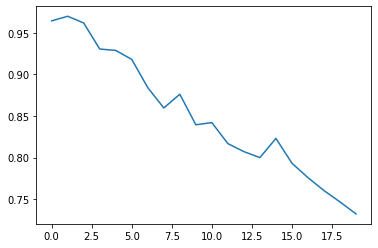

In [8]:
## Creating and testing model with num_epochs = 20 epochs, learning rate = 1, batch_size = 10 and 100 images

# Extracting first 100 images from the dataset
x_train = X_Train[:, : 100]
y_train = y_Train[:, : 100]

# Setting model parameters and hyper-parameters
print("======================================================================================================")
model_architecture = [784, 16, 16, 10]
model_ac_funcs = ["sigmoid", "sigmoid", "sigmoid"]
num_epochs = 20
learning_rate = 1
batch_size = 10
model = ANN_Model(model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size)
print("Creating ANN model with {} layers with {} neurons, number of epochs = {}, learning-rate = {} and batch size = {}".format(len(model_architecture), model_architecture, num_epochs, learning_rate, batch_size))

# Initializing model weights and biases
model.initialize_weights_and_biases()

# Calculate and display the accuracy of the untrained model (with random weights and zero biases) based on the first 100 images
print("======================================================================================================")
print("Testing untrained model with first 100 images of dataset")
model.forward_propagation(x_train)
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for random weight values and zero bias values".format(accuracy*100))

# Training model with first 100 images (non-vectorized)
print("======================================================================================================")
print("Training and testing model with first 100 images of dataset (non-vectorized)")
start_training_time = time.time()
model.train(x_train, y_train, False)
end_training_time = time.time()
print("It took {} seconds to train the model with non-vectorized backward propagation function".format(end_training_time - start_training_time))
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for trained model with trained data".format(accuracy*100))

# Plotting cost values
plt.plot(np.array(model.trained_cost))
plt.show()

Creating ANN model with 4 layers with [784, 16, 16, 10] neurons, number of epochs = 20, learning-rate = 1 and batch size = 10
Testing untrained model with first 100 images of dataset
The accuracy of the model is 14.000000000000002 % for random weight values and zero bias values
Training and testing model with first 100 images of dataset (vectorized)
It took 0.11170053482055664 seconds to train the model with vectorized backward propagation function
The accuracy of the model is 72.0 % for trained model with trained data


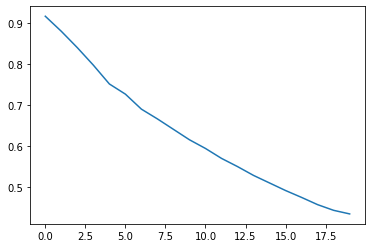

In [9]:
## Creating and testing model with num_epochs = 20 epochs, learning rate = 1, batch_size = 10 and 100 images

# Extracting first 100 images from the dataset
x_train = X_Train[:, : 100]
y_train = y_Train[:, : 100]

# Setting model parameters and hyper-parameters
print("======================================================================================================")
model_architecture = [784, 16, 16, 10]
model_ac_funcs = ["sigmoid", "sigmoid", "sigmoid"]
num_epochs = 20
learning_rate = 1
batch_size = 10
model = ANN_Model(model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size)
print("Creating ANN model with {} layers with {} neurons, number of epochs = {}, learning-rate = {} and batch size = {}".format(len(model_architecture), model_architecture, num_epochs, learning_rate, batch_size))

# Initializing model weights and biases
model.initialize_weights_and_biases()

# Calculate and display the accuracy of the untrained model (with random weights and zero biases) based on the first 100 images
print("======================================================================================================")
print("Testing untrained model with first 100 images of dataset")
model.forward_propagation(x_train)
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for random weight values and zero bias values".format(accuracy*100))

# Training model with first 100 images (vectorized)
print("======================================================================================================")
print("Training and testing model with first 100 images of dataset (vectorized)")
start_training_time = time.time()
model.train_vectorized(x_train, y_train, False)
end_training_time = time.time()
print("It took {} seconds to train the model with vectorized backward propagation function".format(end_training_time - start_training_time))
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for trained model with trained data".format(accuracy*100))

# Plotting cost values
plt.plot(np.array(model.trained_cost))
plt.show()

Creating ANN model with 4 layers with [784, 16, 16, 10] neurons, number of epochs = 5, learning-rate = 1 and batch size = 50
Testing untrained model with first 100 images of dataset
The accuracy of the model is 9.865 % for random weight values and zero bias values
Training and testing model all images of dataset (vectorized)
It took 5.365295648574829 seconds to train the model with vectorized backward propagation function
The accuracy of the model is 90.21166666666667 % for trained model with trained data
The accuracy of the model is 89.96 % for trained model with test data


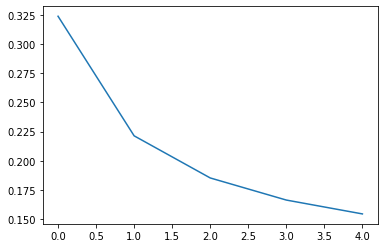

In [10]:
## Creating and testing model with num_epochs = 5 epochs, learning rate = 1, batch_size = 50 

# Extracting all images from the dataset
x_train = X_Train[:, :]
y_train = y_Train[:, :]
x_test = X_Test[:, :]
y_test = y_Test[:, :]

# Setting model parameters and hyper-parameters
print("======================================================================================================")
model_architecture = [784, 16, 16, 10]
model_ac_funcs = ["sigmoid", "sigmoid", "sigmoid"]
num_epochs = 5
learning_rate = 1
batch_size = 50
model = ANN_Model(model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size)
print("Creating ANN model with {} layers with {} neurons, number of epochs = {}, learning-rate = {} and batch size = {}".format(len(model_architecture), model_architecture, num_epochs, learning_rate, batch_size))

# Initializing model weights and biases
model.initialize_weights_and_biases()

# Calculate and display the accuracy of the untrained model (with random weights and zero biases) based on the first 100 images
print("======================================================================================================")
print("Testing untrained model with first 100 images of dataset")
model.forward_propagation(x_train)
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for random weight values and zero bias values".format(accuracy*100))

# Training model all images (vectorized)
print("======================================================================================================")
print("Training and testing model all images of dataset (vectorized)")
start_training_time = time.time()
model.train_vectorized(x_train, y_train, False)
end_training_time = time.time()
print("It took {} seconds to train the model with vectorized backward propagation function".format(end_training_time - start_training_time))
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for trained model with trained data".format(accuracy*100))
accuracy = model.calculate_accuracy(x_test, y_test)
print("The accuracy of the model is {} % for trained model with test data".format(accuracy*100))

# Plotting cost values
plt.plot(np.array(model.trained_cost))
plt.show()

Creating ANN model with 4 layers with [784, 16, 16, 10] neurons, number of epochs = 5, learning-rate = 1 and batch size = 50
Testing untrained model with first 100 images of dataset
The accuracy of the model is 9.545 % for random weight values and zero bias values
Training and testing model all images of dataset (vectorized)
It took 5.46219277381897 seconds to train the model with vectorized backward propagation function
The accuracy of the model is 88.96166666666666 % for trained model with trained data
The accuracy of the model is 88.5 % for trained model with test data


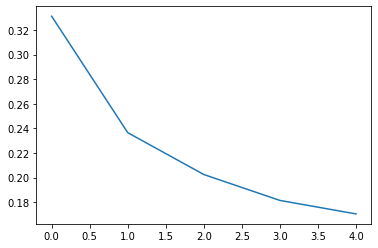

In [11]:
## Creating and testing model with num_epochs = 5 epochs, learning rate = 1, batch_size = 50 

# Extracting all images from the dataset
x_train = X_Train[:, :]
y_train = y_Train[:, :]
x_test = X_Test[:, :]
y_test = y_Test[:, :]

# Setting model parameters and hyper-parameters
print("======================================================================================================")
model_architecture = [784, 16, 16, 10]
model_ac_funcs = ["sigmoid", "sigmoid", "softmax"]
num_epochs = 5
learning_rate = 1
batch_size = 50
model = ANN_Model(model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size)
print("Creating ANN model with {} layers with {} neurons, number of epochs = {}, learning-rate = {} and batch size = {}".format(len(model_architecture), model_architecture, num_epochs, learning_rate, batch_size))

# Initializing model weights and biases
model.initialize_weights_and_biases()

# Calculate and display the accuracy of the untrained model (with random weights and zero biases) based on the first 100 images
print("======================================================================================================")
print("Testing untrained model with first 100 images of dataset")
model.forward_propagation(x_train)
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for random weight values and zero bias values".format(accuracy*100))

# Training model all images (vectorized)
print("======================================================================================================")
print("Training and testing model all images of dataset (vectorized)")
start_training_time = time.time()
model.train_vectorized(x_train, y_train, False)
end_training_time = time.time()
print("It took {} seconds to train the model with vectorized backward propagation function".format(end_training_time - start_training_time))
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for trained model with trained data".format(accuracy*100))
accuracy = model.calculate_accuracy(x_test, y_test)
print("The accuracy of the model is {} % for trained model with test data".format(accuracy*100))

# Plotting cost values
plt.plot(np.array(model.trained_cost))
plt.show()

In [ ]:
## Creating and testing model with num_epochs = 100 epochs, learning rate = 0.1, batch_size = 50 

# Extracting all images from the dataset
x_train = X_Train[:, :]
y_train = y_Train[:, :]
x_test = X_Test[:, :]
y_test = y_Test[:, :]

# Setting model parameters and hyper-parameters
print("======================================================================================================")
model_architecture = [784, 16, 16, 10]
model_ac_funcs = ["relu", "sigmoid", "softmax"]
num_epochs = 100
learning_rate = 0.1
batch_size = 50
model = ANN_Model(model_architecture, model_ac_funcs, num_epochs, learning_rate, batch_size)
print("Creating ANN model with {} layers with {} neurons, number of epochs = {}, learning-rate = {} and batch size = {}".format(len(model_architecture), model_architecture, num_epochs, learning_rate, batch_size))

# Initializing model weights and biases
model.initialize_weights_and_biases()

# Calculate and display the accuracy of the untrained model (with random weights and zero biases) based on the first 100 images
print("======================================================================================================")
print("Testing untrained model with first 100 images of dataset")
model.forward_propagation(x_train)
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for random weight values and zero bias values".format(accuracy*100))

# Training model all images (vectorized)
print("======================================================================================================")
print("Training and testing model all images of dataset (vectorized)")
start_training_time = time.time()
model.train_vectorized(x_train, y_train, False)
end_training_time = time.time()
print("It took {} seconds to train the model with vectorized backward propagation function".format(end_training_time - start_training_time))
accuracy = model.calculate_accuracy(x_train, y_train)
print("The accuracy of the model is {} % for trained model with trained data".format(accuracy*100))
accuracy = model.calculate_accuracy(x_test, y_test)
print("The accuracy of the model is {} % for trained model with test data".format(accuracy*100))

# Plotting cost values
plt.plot(np.array(model.trained_cost))
plt.show()

Creating ANN model with 4 layers with [784, 16, 16, 10] neurons, number of epochs = 100, learning-rate = 0.1 and batch size = 50
Testing untrained model with first 100 images of dataset
The accuracy of the model is 11.093333333333334 % for random weight values and zero bias values
Training and testing model all images of dataset (vectorized)
